# Parkinson diagnosis


This notebooks builds and compares the performance of several machine learning models for the diagnosis of Parkinson disease from a speech features dataset

## Problem statement

The problem in hand is a binary classification problem involving a large number of features. Here the inputs are some characteristics of speech (related for example to time frequency, wavelets transformation,... ), while the output is binary, i.e 1 for patients diagnosed with a Parkinson disease or 0 for control participants. 

So the method to approach this would be to understand the significance of the features, execute some strategies for feature reduction, apply several binary classification algorithms and compare there performances.  

In short, the objective of this study is to build a predictive model for the diagnosis of Parkinson disease.

## Loading packages

In [20]:
#from __future__ import absolute_import, division, print_function, unicode_literals



# Helper libraries
import csv 
import collections
import pandas as pd
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
## ou remplacer les 2 lignes précédente par: %pylab inline

import seaborn as sb

import warnings

from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate




Populating the interactive namespace from numpy and matplotlib


# Load and explore the data

In [4]:
# Read and store the data in a dataframe
data = pd.read_csv('data/pd_speech_features.csv', skiprows=1)

# Visualize dataframe first rows 
data.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


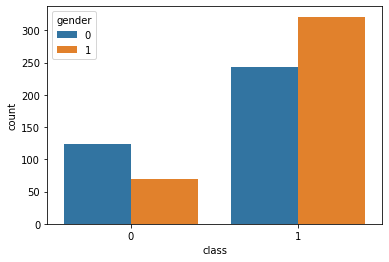

In [6]:
sb.countplot(x="class", hue="gender", data=data)

The dataset has 756 rows ((188+64)*3) and 755 columns. Amongst the 755 columns, the first one is an `id` number (from 0 to 251), the second one is the `gender` of participant (0=female, 1=male) and the last one is the `class` (0=control, 1=patient). The other 753 columns correspond to various features extracted with voice signal processing algorithms and related to five main categories: 


*   Time frequency characteristics
*   Mel frequency cephalic coefficients (MFCCs)
*   Wavelet transformation-based characteristics
*   Voice fold characteristics
*   TQWT characteristics

All feature have numerical values (float or int types). 

The class distribution of the samples is such that 546 are patients and 192 are control participants, which is imbalanced.








## Separate data in labels and features

In [7]:
y = data['class']
X = data.drop(['class','id'],axis=1)

# Feature selection

The dataset provides 753 features, which is a large number and can lead to two major problems: 


1.   First, the more features you have, the more likely you are to overfit to the training and validation sets. This will cause your model to perform worse at generalizing to new data.
2.   Secondly, the more features you have, the longer it will take to train your model and optimize hyperparameters. Also, when building user-facing products, you'll want to make inference as fast as possible. Using fewer features can speed up inference at the cost of predictive performance.

To help with these issues, we want to use feature selection techniques to keep the most informative features for our model.

In [8]:
X.describe()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,...,21.026054,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110
std,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,...,43.716898,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991
min,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,6.860000e-07,...,1.342700,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000
25%,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,5.260000e-06,...,1.814850,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750
50%,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,9.530000e-06,...,3.075050,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250
75%,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,1.832500e-05,...,12.129975,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325
max,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,2.564800e-04,...,355.516100,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700


The dataframe above provides us some interesting information about each feature (number of values, mean value, standard deviation,...). We will now look closely at the data to answer the following questions: 
*   Are some values missing? 
*   Do some columns contain a constant (or quasi-constant) value ? 
*   Are some columns duplicated ? 





## Missing values



In [9]:
# Get names of columns with missing values
cols_with_missing = [col for col in X.columns
                     if X[col].isnull().any()]
print(cols_with_missing)

[]


No missing values.

## Constant features

Constant features are those that show the same value, just one value, for all the observations of the dataset. This is, the same value for all the rows of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target. Identifying and removing constant features. To identify constant features, we can use the VarianceThreshold function from sklearn.

In [10]:
varModel=feature_selection.VarianceThreshold(threshold=0) #Setting variance threshold to 0 which means features that have same value in all samples.
varModel.fit(X)

constArr=varModel.get_support()
constArr
#get_support() return True and False value for each feature.
#True: Not a constant feature
#False: Constant feature(It contains same value in all samples.)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

No feature has a constant value.

## Quasi-constant features

Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. Mostly we do not consider these features in prediting the result.

In [11]:
# Get names of columns having less than 10 different values
quasiCols=[col for col in X.columns if len(X[col].unique())<10]
quasiCols

['gender']

## Duplicated Features

Often datasets contain one or more features that show the same values across all the observations. This means that both features are in essence identical.

In [12]:
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

In [13]:
# Get list of duplicate columns
duplicateColumnNames = getDuplicateColumns(X)
 
print('Duplicate Columns are as follows:')
for col in duplicateColumnNames:
    print('Column name : ', col)

Duplicate Columns are as follows:


We find no duplicated columns in our dataset.


After checking the data, we can conclude that the dataset is clean (no missing values, duplicated columns,...) but it didn't help us to reduce the number of features for the analysis and we still have 753 features. It could be interesting to plot variable distributions to identify outliers or correlation matrix to remove features highly correlated but we still have too many features to do this at this stage. 

We will later use feature selection techniques (PCA, Univariate Feature Selection) to keep the most informative features for our model.

# Classification algorithms

The problem here is a standard binary classification. It has two classes and 753 numeric input variables of varying scales.
We will select three algorithms for binary classification and compare their performances. We will test the following algorithms:
* Logistic Regression
* K-Nearest Neighbors
* Decision Tree

Each algorithm is given a short name, useful for summarizing results afterward.

In [14]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))


We will bundle preprocessing, feature selection and modeling code in a pipeline to evaluate the performance of the three algorithms for our classification task. We use a cross validation procedure.

The pipeline provides a handy tool called the FeatureUnion which allows the results of multiple feature selection and extraction procedures to be combined into a larger dataset on which a model can be trained. Importantly, all the feature extraction and the feature union occurs within each fold of the cross validation procedure.

In [16]:
warnings.filterwarnings("ignore")

# Preprocessing : standardisation 
scaler = StandardScaler()

# Feature selection : FeatureUnion PCA and Univariate Feature Selection
feature_union = FeatureUnion([('pca', PCA(n_components=5)),('select_best', SelectKBest(k=100))])

# Scores to return
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']

df=pd.DataFrame() 

# Iterate on the three algo to test
for name, model in models:
  # create pipeline
    estimators = []
    estimators.append(('scaler', scaler))
    estimators.append(('feature_union', feature_union))
    estimators.append(('model', model))
    pipe = Pipeline(estimators)

    kfold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0) # keeps the class proportions the same across all of the folds
    cv_results = cross_validate(pipe, X, y, cv=kfold, scoring=scoring)
  
    temp_df = pd.DataFrame() 
  
    for key in cv_results.keys():
        temp_df[key]=cv_results[key]
        
    temp_df.insert(0,"Name",name)

    # Return a dataframe containing scoring of each CV of each model
    df = df.append(temp_df)

print(df)

  Name  fit_time  score_time  test_accuracy  test_precision  test_recall  \
0   LR  0.109218    0.018996       0.792208        0.847458     0.877193   
1   LR  0.087474    0.020110       0.844156        0.868852     0.929825   
2   LR  0.087920    0.019515       0.855263        0.870968     0.947368   
3   LR  0.089153    0.018514       0.855263        0.870968     0.947368   
4   LR  0.092216    0.019428       0.773333        0.830508     0.875000   
5   LR  0.085589    0.018869       0.760000        0.851852     0.821429   
6   LR  0.088004    0.019516       0.853333        0.868852     0.946429   
7   LR  0.089335    0.018776       0.880000        0.912281     0.928571   
8   LR  0.088597    0.018943       0.773333        0.842105     0.857143   
9   LR  0.090818    0.018698       0.800000        0.847458     0.892857   
0  KNN  0.075421    0.062264       0.870130        0.898305     0.929825   
1  KNN  0.065313    0.063805       0.870130        0.885246     0.947368   
2  KNN  0.06

In [17]:
grouped = df.groupby('Name')
grouped.agg([np.mean, np.std])

fit_time           score_time           test_accuracy            \
          mean       std       mean       std          mean       std   
Name                                                                    
DT    0.128569  0.011102   0.019311  0.000611      0.806880  0.027104   
KNN   0.065634  0.003483   0.063868  0.003841      0.851728  0.014960   
LR    0.090832  0.006710   0.019137  0.000490      0.818689  0.043324   

     test_precision           test_recall             test_f1            \
               mean       std        mean       std      mean       std   
Name                                                                      
DT         0.864902  0.020641    0.879386  0.044678  0.871277  0.021151   
KNN        0.868476  0.017430    0.945019  0.021246  0.904854  0.009430   
LR         0.861130  0.022825    0.902318  0.044098  0.880950  0.030156   

     test_roc_auc            
             mean       std  
Name                         
DT       0.736272  0.035229  
KNN      0.905416  0.023696  
LR       0.863288  0.038247

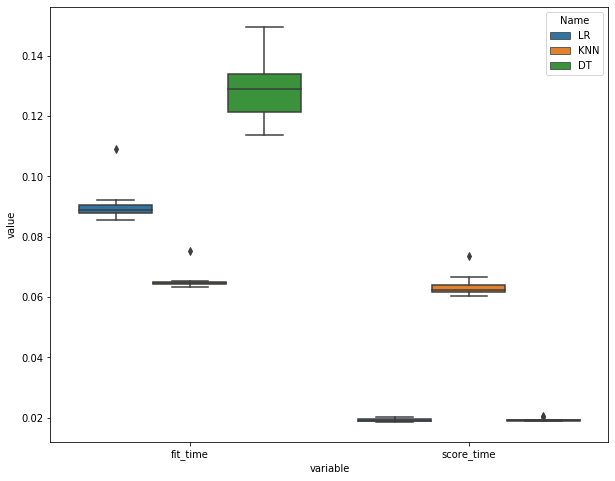

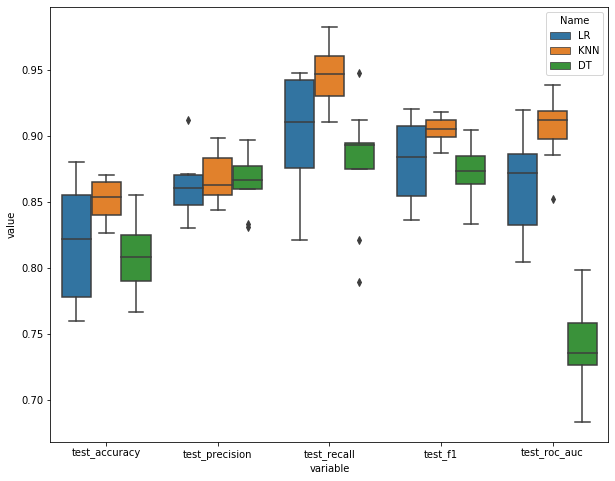

In [18]:
# Plot mean scores across cross validation iterations for the three models 
dd1=pd.melt(df,id_vars=['Name'],value_vars=['fit_time','score_time'])
dd2 = pd.melt(df,id_vars=['Name'],value_vars=['test_accuracy','test_precision','test_recall','test_f1','test_roc_auc'])

plt.figure(figsize=(10,8))
sb.boxplot(y='value',x='variable',data=dd1,orient="v",hue='Name')
plt.figure(figsize=(10,8))
sb.boxplot(y='value',x='variable',data=dd2,orient="v",hue='Name')

kNN algorithm provides the best results for almost each score. From these results, it would suggest that this algorithm is worthy of further study on this problem.

## Optimize hyper-parameters 

We use a Grid Search to optimize parameters of a kNN classifier, in order to achieve the best performance (measured here in terms of F-score) for our classication task.

In [21]:
# Split the entire dataset in a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessing : standardisation 
scaler = StandardScaler()

# Feature selection : FeatureUnion PCA and Univariate Feature Selection
feature_union = FeatureUnion([('pca', PCA(n_components=5)),('select_best', SelectKBest(k=100))])

# Model
model = KNeighborsClassifier()

# Pipeline
estimators = []
estimators.append(('scaler', scaler))
estimators.append(('feature_union', feature_union))
estimators.append(('model', model))
pipe = Pipeline(estimators)

# Score to optimize 
score = 'f1'

# Values of parameters to evaluate 
k_range = [3,5,7,9,11,13,15,17]
leaf_size = [5,10,20,30,50]

params = {'model__n_neighbors':k_range,
         'model__leaf_size':leaf_size}

# Cross validation
cross_validation = model_selection.StratifiedKFold(n_splits=10,random_state=0)

# Conduct parameter optmization with Pipeline
# Create a grid search object
grid_search = GridSearchCV(pipe,
                           param_grid=params,
                           cv=cross_validation,
                           verbose=1,
                           scoring=score,
                           n_jobs=-1)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pca',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            n_components=5,
                                                                            random_state=None

In [22]:
# View The Best Parameters on training set
print('Best parameters on training set: {}'.format(grid_search.best_params_))


# Print the corresponding performances
print("Results of cross validation :")
for mean, std, params in zip(grid_search.cv_results_['mean_test_score'],grid_search.cv_results_['std_test_score'],
                             grid_search.cv_results_['params']):

  print('\t%s = %0.3f (+/-%0.03f) for %r'% (score, # score optimized (f1)
  mean, # mean score
  std * 2, # error 
  params # hyperparameter
  ))

Best parameters on training set: {'model__leaf_size': 5, 'model__n_neighbors': 3}
Results of cross validation :
	f1 = 0.901 (+/-0.049) for {'model__leaf_size': 5, 'model__n_neighbors': 3}
	f1 = 0.895 (+/-0.046) for {'model__leaf_size': 5, 'model__n_neighbors': 5}
	f1 = 0.888 (+/-0.056) for {'model__leaf_size': 5, 'model__n_neighbors': 7}
	f1 = 0.885 (+/-0.070) for {'model__leaf_size': 5, 'model__n_neighbors': 9}
	f1 = 0.886 (+/-0.069) for {'model__leaf_size': 5, 'model__n_neighbors': 11}
	f1 = 0.886 (+/-0.068) for {'model__leaf_size': 5, 'model__n_neighbors': 13}
	f1 = 0.886 (+/-0.068) for {'model__leaf_size': 5, 'model__n_neighbors': 15}
	f1 = 0.884 (+/-0.069) for {'model__leaf_size': 5, 'model__n_neighbors': 17}
	f1 = 0.901 (+/-0.049) for {'model__leaf_size': 10, 'model__n_neighbors': 3}
	f1 = 0.895 (+/-0.046) for {'model__leaf_size': 10, 'model__n_neighbors': 5}
	f1 = 0.888 (+/-0.056) for {'model__leaf_size': 10, 'model__n_neighbors': 7}
	f1 = 0.885 (+/-0.070) for {'model__leaf_size

''

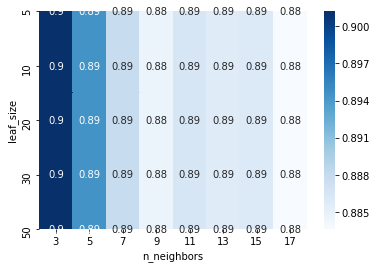

In [23]:
#visualize the grid search to see how the parameters interact
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 8)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['model__leaf_size'])
plt.xticks(np.arange(8) + 0.5, grid_search.param_grid['model__n_neighbors'])
plt.ylabel('leaf_size')
plt.xlabel('n_neighbors')
;

In [24]:
# Performance of the best parameters selected from training on the test set
from sklearn import metrics
y_pred = grid_search.predict(X_test)
print('F-Score on test set: {}'.format(metrics.f1_score(y_test, y_pred)))

F-Score on test set: 0.9068825910931175
